# A) Data wrangling and training phase
   # Importing libraries and reading the file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
train_df=pd.read_csv('datasets/train.csv')

In [3]:
train_df['Target']=train_df['Survived'].astype(int)
train_df['Survived']=train_df['Survived'].map({1:'Yes',0:'No'})
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Target
0,1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,Yes,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,Yes,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,No,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [4]:
gender_df=pd.read_csv('datasets/gender_submission.csv')
gender_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Our final file should look like the above dataframe

# Checking for NaN values in our dataframe

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null object
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Target         891 non-null int64
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [6]:
train_df['PassengerId'].isnull().any()

False

In [7]:
train_df['Pclass'].isnull().any()

False

In [8]:
train_df['Name'].isnull().any()

False

In [9]:
train_df['Sex'].isnull().any()

False

In [10]:
train_df['Age'].isnull().any()

True

As we can see, there are ages that are missing. Let us see how many.

In [11]:
train_df['Age'].isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

Hence, we have 177 entries with NaN values.

In [12]:
train_df['SibSp'].isnull().any()

False

The above column shows number of siblings or spouses.

In [13]:
train_df['Parch'].isnull().any()

False

Shows number of parents or children aboard

In [14]:
train_df['Cabin'].isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

We have 687 cases with no cabin info

In [15]:
train_df['Embarked'].isnull().value_counts()

False    889
True       2
Name: Embarked, dtype: int64

# Data Visualisation

Let us visualise the data of each field so that we can understand how to deal with the NaN values.

## 1. Age

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


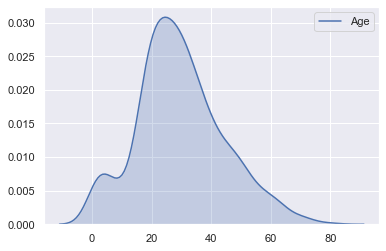

In [16]:
sns.kdeplot(train_df['Age'],shade=True)

The above distribution looks bimodal in nature containing two peaks. Most passengers were between 20-40

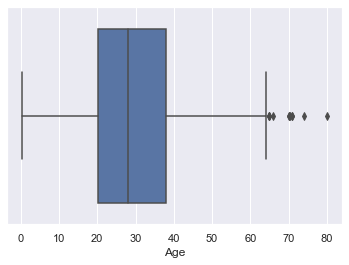

In [17]:
sns.boxplot('Age',data=train_df)

In [18]:
train_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [19]:
train_df['Age'].median()

28.0

Instead of using a mean age of 29.7 (or 30) , we should select median age to replace the NaN values.

In [20]:
train_df['Age'].fillna(train_df['Age'].median(),inplace=True)

In [21]:
train_df['Age'].isna().any()

False

Hence, all missing values of Age has been taken care of. Let us now plot a histogram to check which age groups are maximum in the Titanic passengers.

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 <a list of 11 Text major ticklabel objects>)

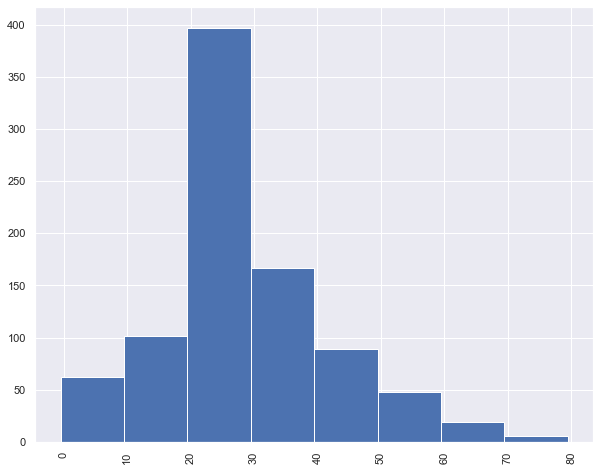

In [22]:
bins=np.arange(0,90,10) - 0.5
plt.figure(figsize=(10,8))
plt.hist(train_df['Age'],bins=bins)
plt.xticks(rotation=90)

As we can see, ages between 20-30 is the highest followed by 30-40.

Let us make another age group for children. Ages lower than 16 will be considered as a child. This way, we can segregate the children from the list of passengers.

In [23]:
def child(passenger):
    age,sex=passenger
    if age<16:
        return 'child'
    else:
        return sex

In [24]:
train_df['Person']=train_df[['Age','Sex']].apply(child,axis=1)

In [25]:
train_df['Person'].value_counts()

male      537
female    271
child      83
Name: Person, dtype: int64

Let us check the age distribution of all adults and children.

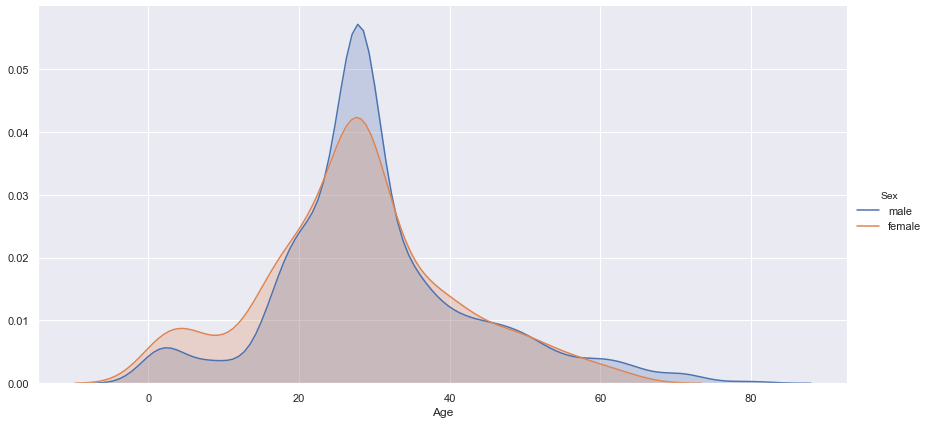

In [26]:
fig1=sns.FacetGrid(train_df,hue='Sex',aspect=2,height=6)
fig1.map(sns.kdeplot,'Age',shade=True)
fig1.add_legend()


For adult males and females, the age distribution is extremely similar. Let us now compare it with the children.

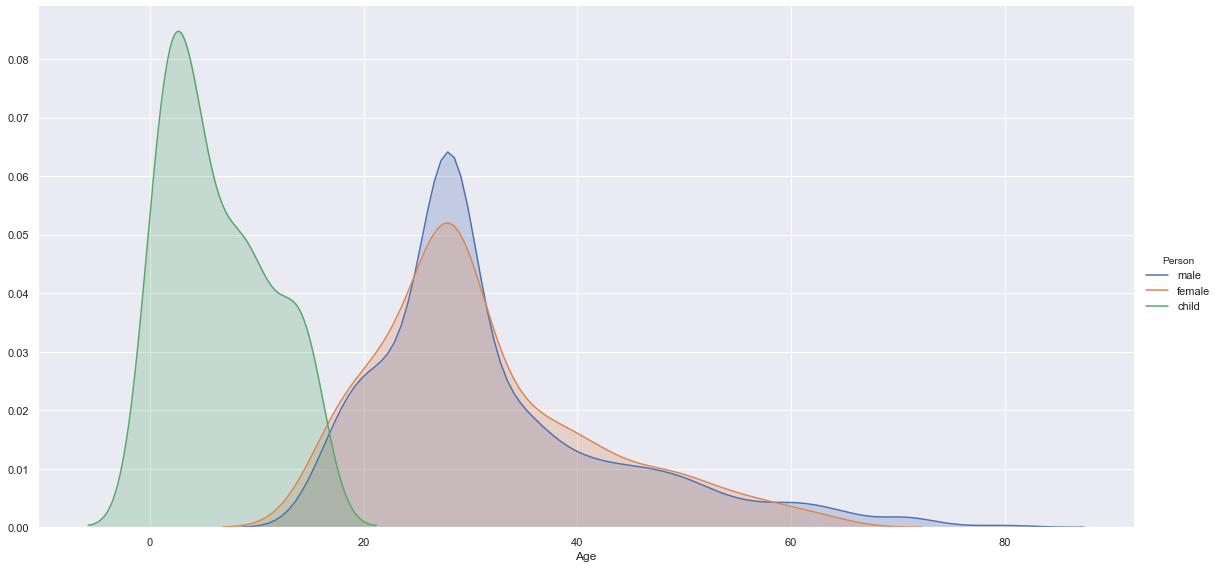

In [27]:
fig2=sns.FacetGrid(train_df,hue='Person',aspect=2,height=8)
fig2.map(sns.kdeplot,'Age',shade=True)
fig2.add_legend()


Let us check if gender or being a child plays a role in survival from the ship.

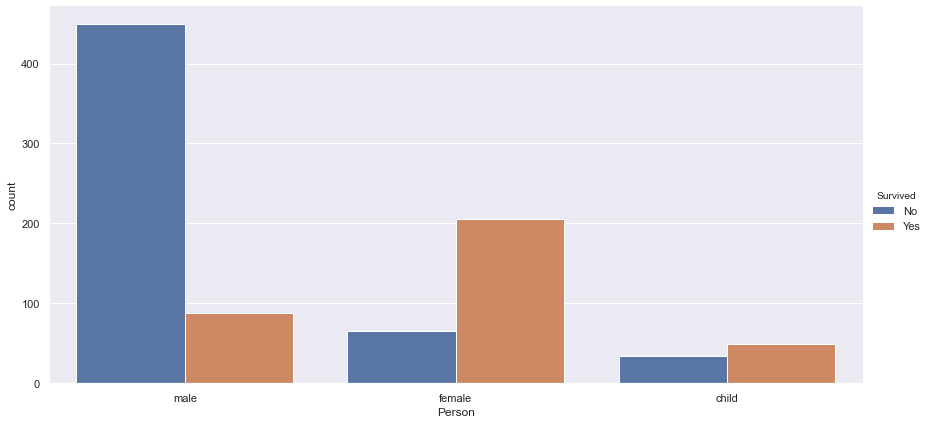

In [28]:
sns.catplot('Person',data=train_df,kind='count',hue='Survived',aspect=2,height=6)

From above data, we can say that maximum number of female adults survived the accident. Most male passengers died. For children, just above 50 percent survived while the rest could not.

The reason could be that most female passengers alongiwith their children were evacuated first from the ship. Males were probably evacuated in the end and hence, could not make it.

Let us now see how age played at important role in survival.

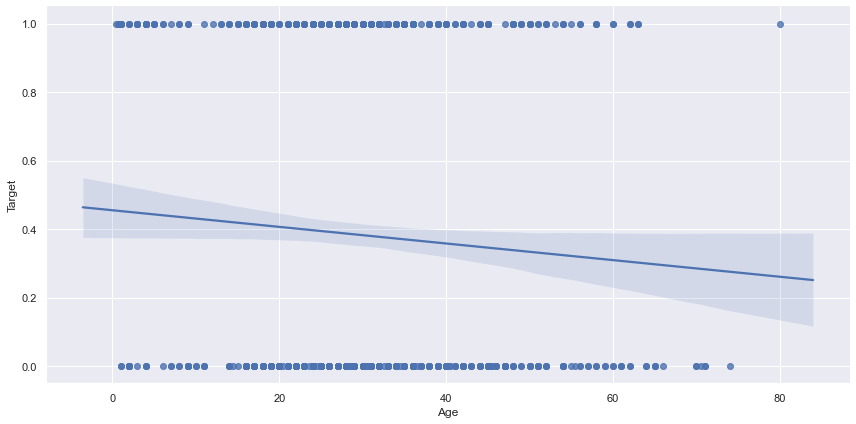

In [29]:
sns.lmplot('Age','Target',data=train_df,aspect=2,height=6)

As we can see, with increase in age, probability of survival decreases. This could be due to the fact that older people found it more difficult to act quickly during the evacuation time as compared to the young and middle aged passengers.


## 2. Embarked

In [30]:
train_df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

* S stands for Southampton.
* C stands for Charlton.
* Q stands for Queenstown.


In [31]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [32]:
train_df['Embarked'].isnull().value_counts()

False    889
True       2
Name: Embarked, dtype: int64

As we can see, there are two passengers whose embarking station isn't mantioned. As max passengers embarked at Southampton, we can make a brute assumption that these 2 passengers may have embarked at Southhampton. Let us replace NaN with S.

In [33]:
train_df['Embarked'].replace(np.nan,'S',inplace=True)

In [34]:
train_df['Embarked'].isnull().any()

False

Let us visualise the data of the embarking stations.

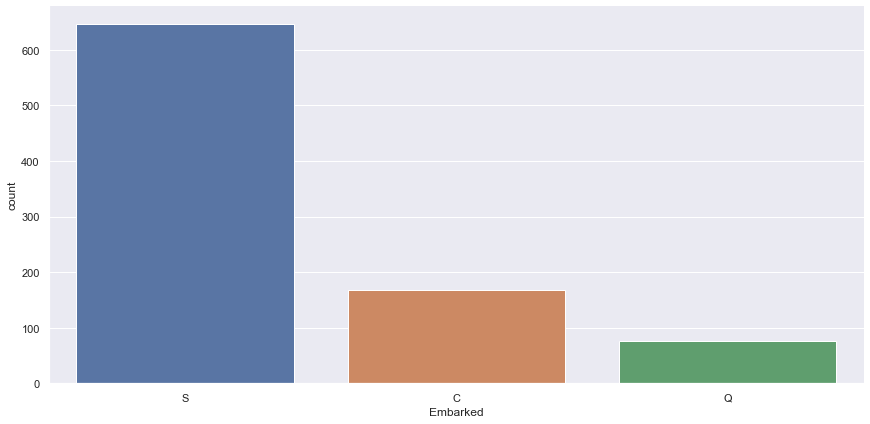

In [35]:
sns.catplot('Embarked',data=train_df,kind='count',aspect=2,height=6)

From the above data, it can be seen that maximum passengers embarked in Southampton followed by Charlton and Queenstown. Let us now check the number of survivors from each of the embarking stations.

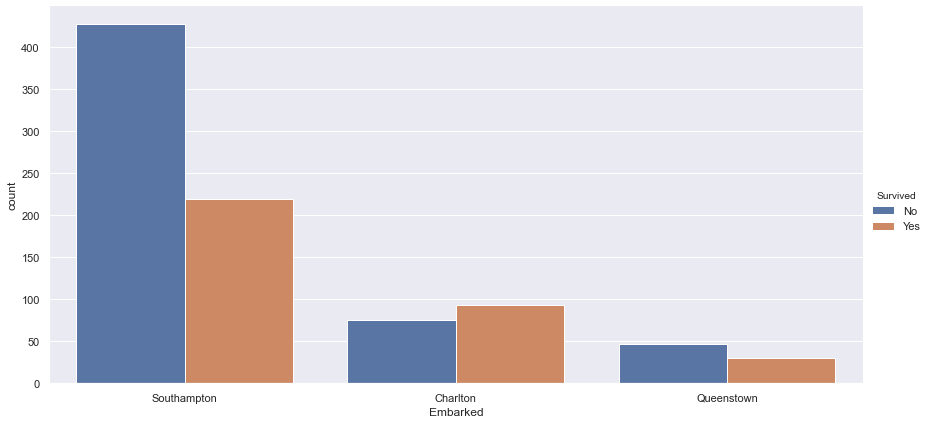

In [36]:
ax=sns.catplot('Embarked',data=train_df,kind='count',hue='Survived',aspect=2,height=6)
ax.set_xticklabels(['Southampton','Charlton','Queenstown'])

## 3. Cabin

This particular feature is extremely problematic due to very high number of missing data. It'll be very difficult to fill null values with any cabin data. It is impossible to try to model this particular data. Hence, it will be wise to simply delete this feature. Inputting a feature with high missing values may induce high bias in our model. Never the less, let us check the correlation with surivival for the data we have.

In [37]:
deck=train_df['Cabin']

In [38]:
deck.isna().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

In [39]:
deck=deck.dropna()

In [40]:
levels=[]
for level in deck:
    levels.append(level[0])
    

In [41]:
cabin_df=pd.DataFrame(levels,columns=['Cabin level'])

In [42]:
cabin_df.head()

,Cabin level
0,C
1,C
2,E
3,G
4,C


In [43]:
cabin_df['Cabin level'].value_counts().sort_values(ascending=False)

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin level, dtype: int64

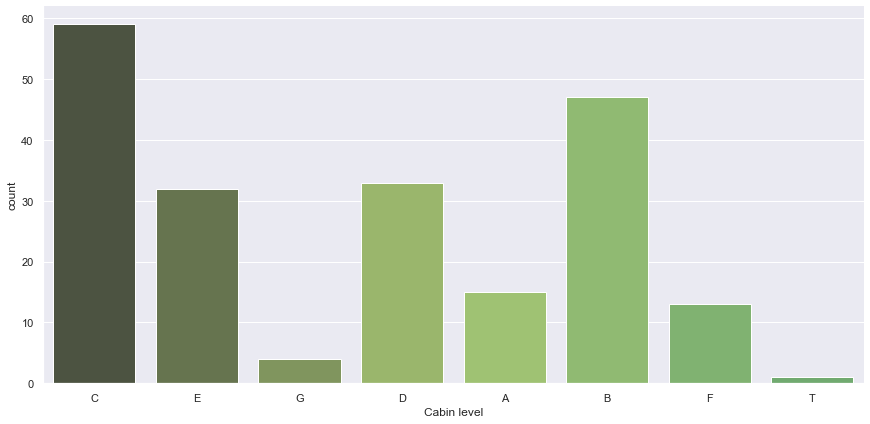

In [44]:
sns.catplot('Cabin level',data=cabin_df,kind='count',aspect=2,height=6,palette='summer_d')

From the available data, we have maximum passengers from level C followed by B.

In [45]:
train_temp=train_df.copy()

In [46]:
train_temp.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
Target         False
Person         False
dtype: bool

In [47]:
train_temp=train_temp.dropna(axis=0)

In [48]:
train_temp.reset_index(inplace=True,drop=True)

In [49]:
train_temp['Level']=cabin_df['Cabin level']

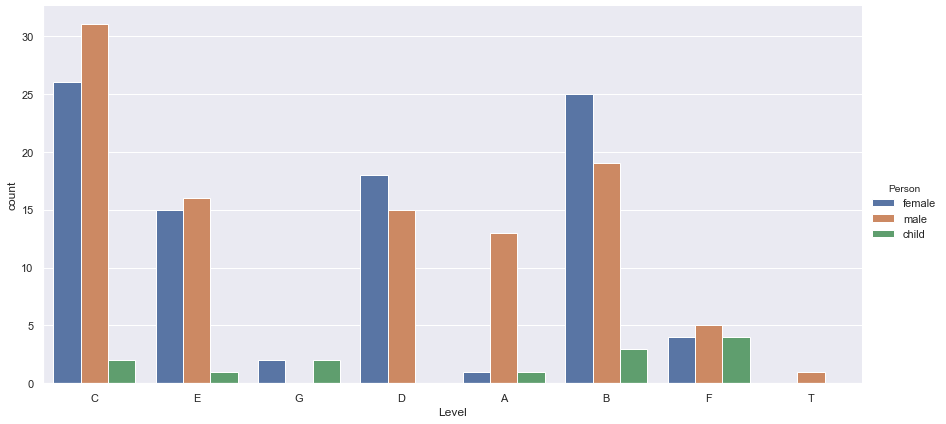

In [50]:
sns.catplot('Level',kind='count',hue='Person',aspect=2,height=6,data=train_temp)

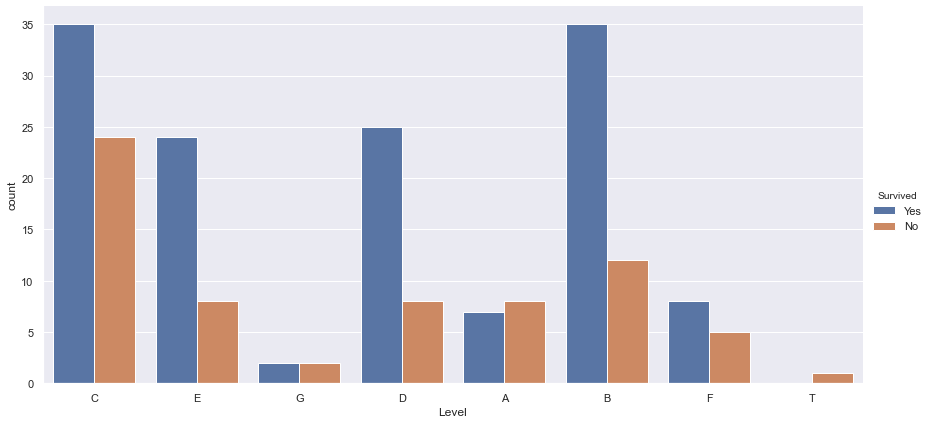

In [51]:
sns.catplot('Level',kind='count',hue='Survived',aspect=2,height=6,data=train_temp)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


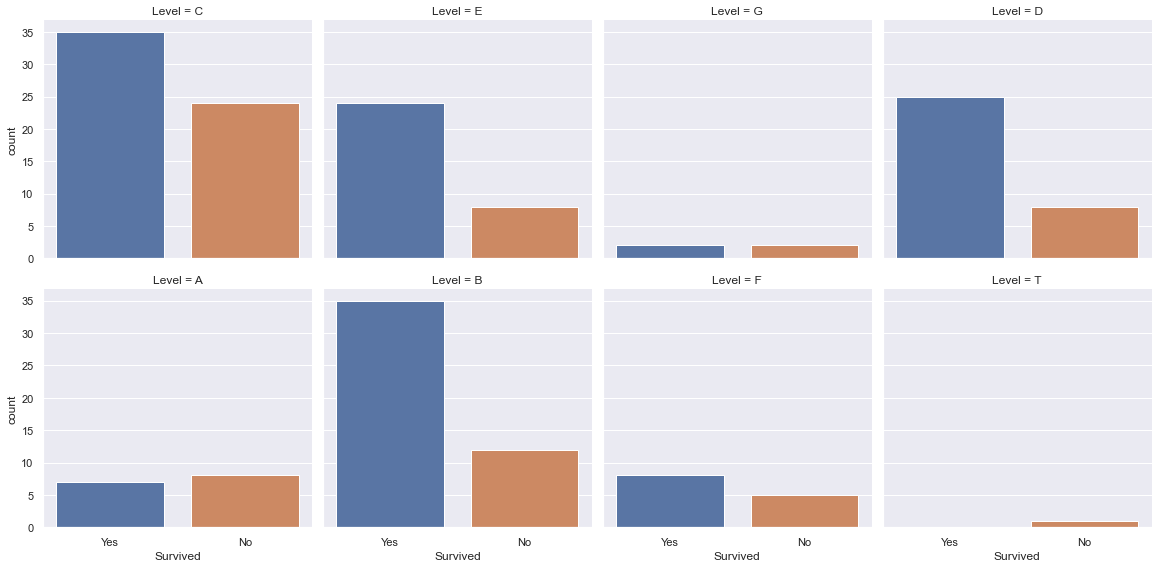

In [52]:
sns.factorplot('Survived',
               data=train_temp,
               kind='count',col='Level',
               col_wrap=4,height=4,aspect=1)

Hence, from the above, we can understand that the level location did have a significant impact on whether the person survived. Higher levels such as level A,B, C and D had good number of survivors. The lower decks had much fewer survivors. However, we can't add it to the model since maximum entries have missing entries. 

## 4. Passenger class

Let us visualise the data for passenger class.

In [53]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

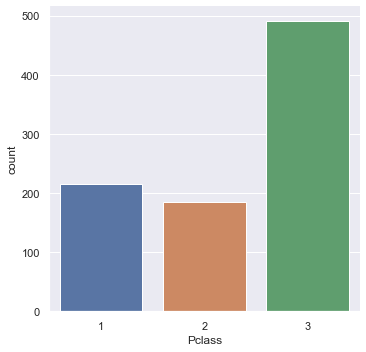

In [54]:
sns.catplot('Pclass',data=train_df, kind='count')

The above data shows that 3rd class passengers were maximum followed by 1st and 2nd class passengers. Let us check if Pclass has any correlation with survival.

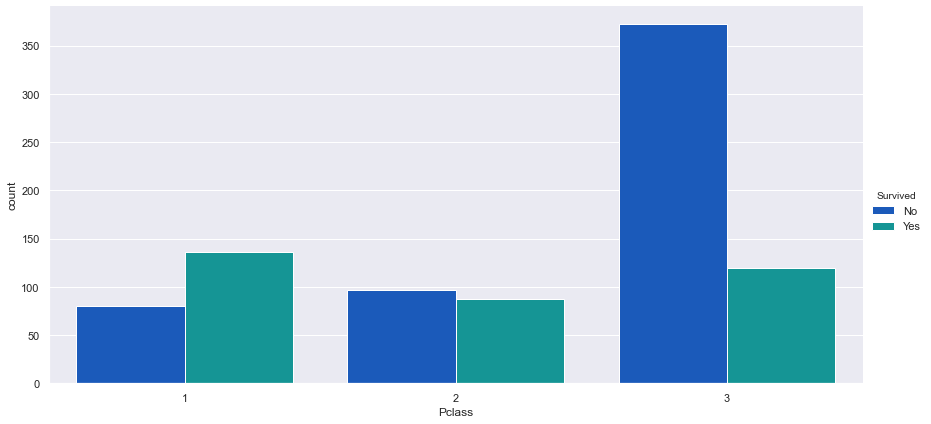

In [55]:
sns.catplot('Pclass',data=train_df,kind='count',hue='Survived',aspect=2,height=6,palette='winter')

It could be said that 1st class passengers could have got a preferential treatment during evacuation process as a result of which, more 1st class passengers survived than ones that didn't. In 2nd class passengers, the survivors and deaths were nearly the same. 

As expected, the 3rd class passengers must have been evacuated in the end and hence, couldn't be saved. It could also be due to the fact that the population of 3rd class passengers were highest. Hence, evacuating the passengers couldn't be completed due to the paucity of time.

To get a better understanding of the survival trend, let us make a lm plot to see the relation between age and survival with a hue of passenger class.

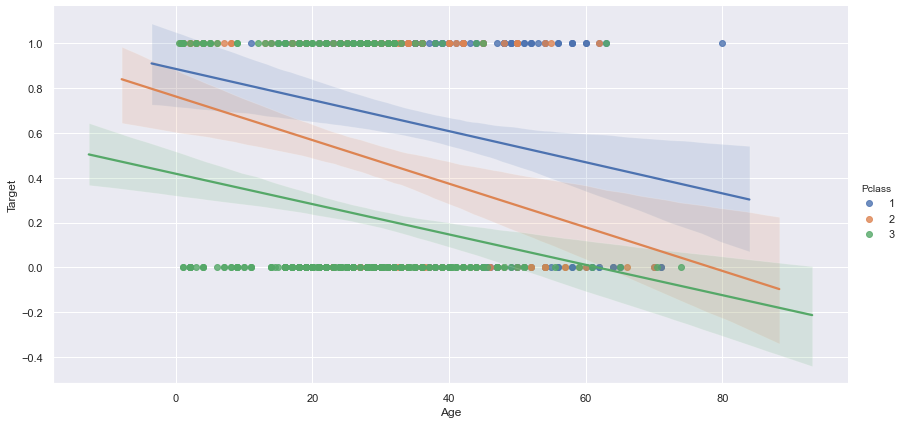

In [56]:
sns.lmplot('Age','Target',data=train_df,aspect=2,height=6,hue='Pclass')

As it can be observed, the probability of survival from the same age group on class 1 was higher than class 3. Hence, it can be said that Passenger Class definitely has a good correlation to survival and will be an important feature of our dataset.

Let us check how the survival of children, male and female adults vary.

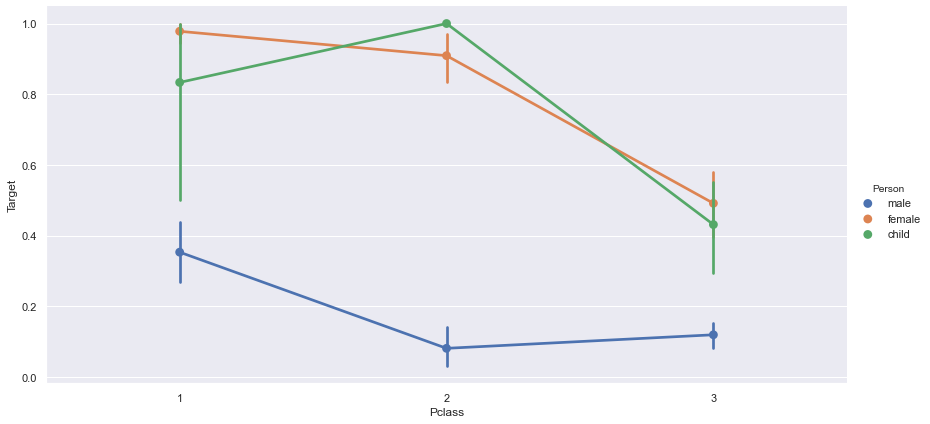

In [57]:
sns.catplot('Pclass','Target',data=train_df,hue='Person',kind='point',aspect=2,height=6)

Here, we can see that for children, max survivors were from 2nd class. For males, 3rd class survivors were higher than 2nd class. This is interesting to note as it was unexpected.

## 5. Siblings and spouses

Let us check if having any siblings and spouses aboard had any relation to survival.

In [58]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

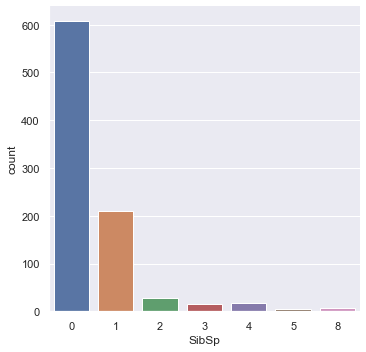

In [59]:
sns.catplot('SibSp',data=train_df,kind='count')

As it can be seen, maximum number of passengers were actually alone. About 209 passengers had either a spouse or a sibling along with them.

Let us now check if this feature realates to survival.


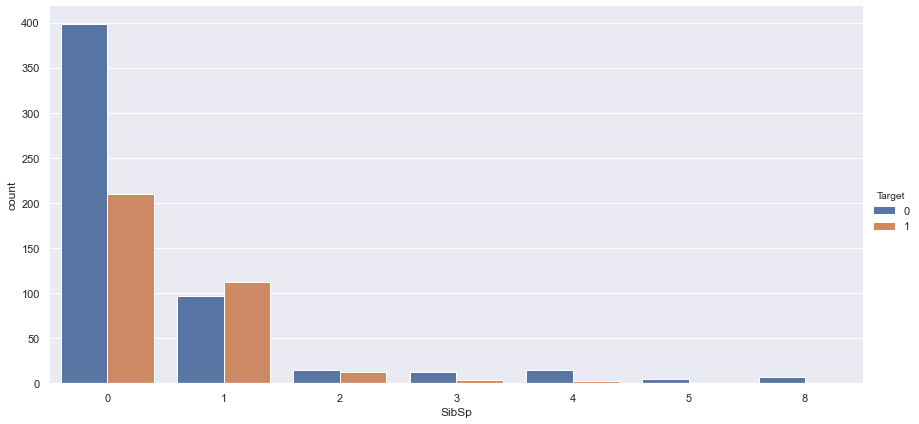

In [60]:
sns.catplot('SibSp',data=train_df,kind='count',hue='Target',aspect=2,height=6)

As is expected, many of the single passengers survived. This could be due to the fact that weren't reqiured to wait for any of the family members to deboard the ship and could be far easily be vacated. Fair number of people with one family member survived since it is realtively easier to find one family member instead of multiple family members.

Hence, it can be said that as family members increases, survival reduced.
Let us check this hypothesis through a lmplot.

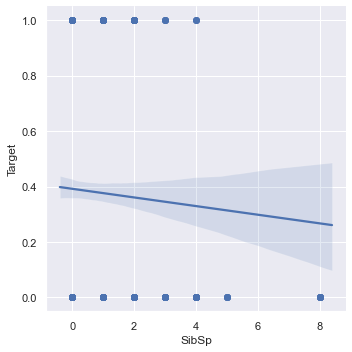

In [61]:
sns.lmplot('SibSp','Target',data=train_df)

The above plot proves our hypothesis that survival chances reduce as number of family members increase.

## 6. Sex

Let us check if gender has any role to play in survival.

In [62]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

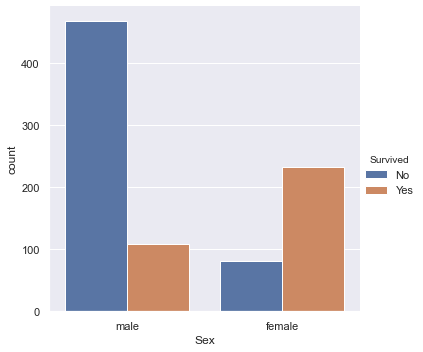

In [63]:
sns.catplot('Sex',data=train_df,kind='count',hue='Survived')

Most of the female passengers survived the accident as compared to males. This indicates that female passengers were evacuated first and hence, they survived. Let us check this with another plot.

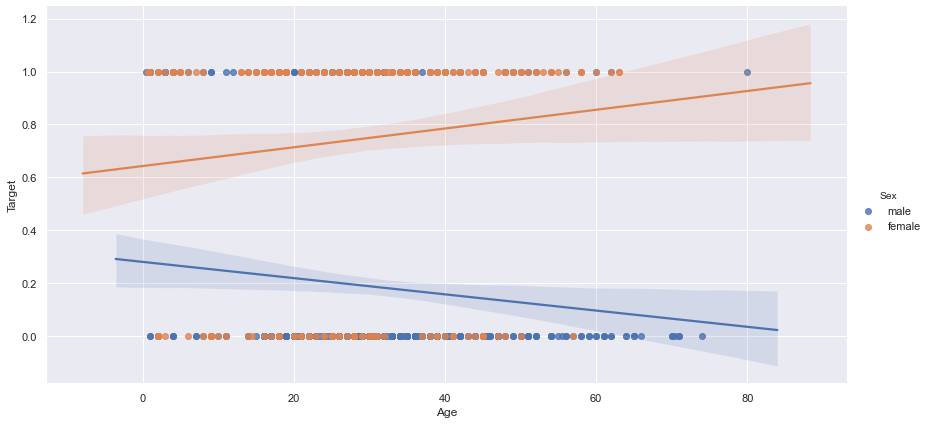

In [64]:
sns.lmplot('Age','Target',data=train_df,hue='Sex',aspect=2,height=6)

The above plot clearly indicates that with age, female passengers actually had a higher probability of survival.

This indicates that aged women were evacuated first and then the middle age and young ones.

For males, it was the opposite. Younger males had higher chance of survival.

## 7. Parents/ Children

Let us check if having any parents or children played any important role in survival of the passengers.

In [65]:
train_df['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [66]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

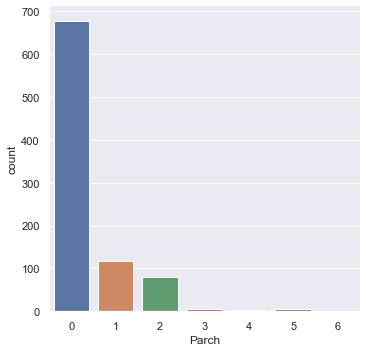

In [67]:
sns.catplot('Parch',data=train_df,kind='count')

As we can see, maximum passengers did not have any children aboard. Let us see if this has any relation with survival.

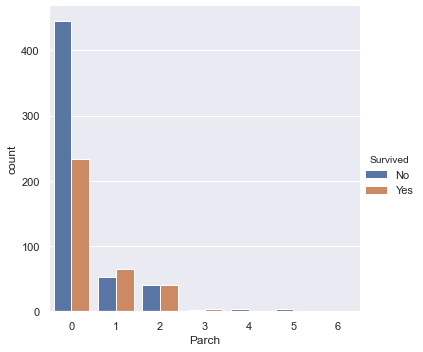

In [68]:
sns.catplot('Parch',data=train_df,kind='count',hue='Survived')

As expected, many passengers who did not have to worry about any children survived. There are about 50% survivors amongst parents with 1 and 2 children aboard.

During the data wrangling process, we can combine the Parch and SibSp columns as with relatives and without relatives to simplify the dataframe and prevent much data leakage. This process is shown below.

In [69]:
train_df['Total relatives']=train_df['Parch']+train_df['SibSp']

In [70]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Target,Person,Total relatives
0,1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,male,1
1,2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,female,1
2,3,Yes,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,female,0
3,4,Yes,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,female,1
4,5,No,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,male,0


Let us check how total relative numbers change the probability of survival.

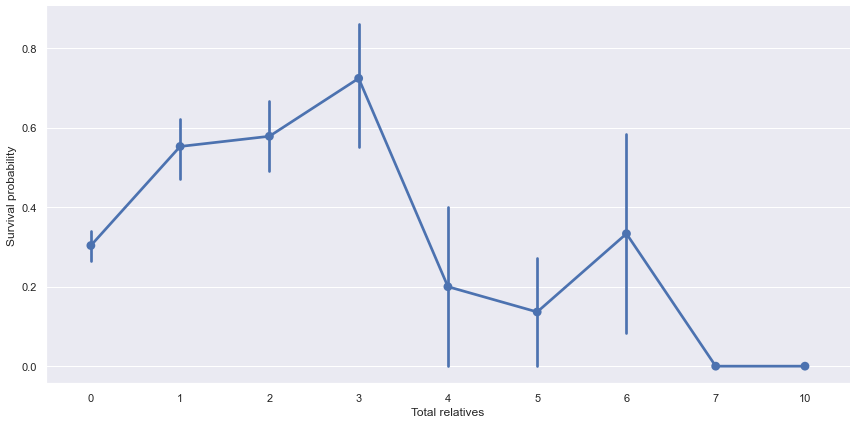

In [71]:
ax=sns.catplot('Total relatives','Target',kind='point',data=train_df,aspect=2,height=6)
ax.set_ylabels('Survival probability')

As we can see from the abpve graph, if there are 0-3 relatives, chances of survival is high. However, anything more than that leads to a drop in survival rate. Hence, we can consider the number of relatives to be an important factor.

## 8. Checking correlation of the various features

Let us check the correlation of the various features with each other using a heatmap.

In [72]:
correlations=train_df.corr()

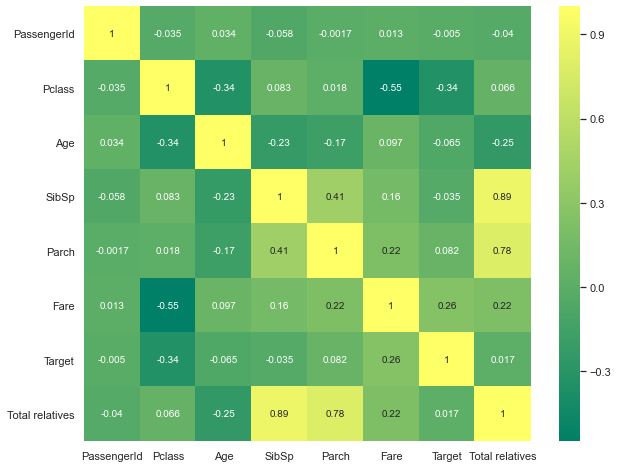

In [73]:
plt.figure(figsize=(10,8))
sns.heatmap(correlations,annot=True,cmap='summer')

## 9. Data Wrangling

We have visualised all the features in the previous sections. Now, we shall make changes to the dataframe to keep only the relevant features. We may modify or drop features such that it shall give us a good model prediction.

In [74]:
train_mod=train_df.copy()

In [75]:
train_mod.columns.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [76]:
train_mod.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Target,Person,Total relatives
0,1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,male,1
1,2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,female,1
2,3,Yes,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,female,0
3,4,Yes,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,female,1
4,5,No,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,male,0


We can drop columns such as *PassengerID,Survived, Name,Sex,SibSp,Parch,Cabin and Ticket*

In [77]:
train_mod.drop(['PassengerId','Survived','Sex','Name','Ticket','Cabin','Parch','SibSp'],axis=1,inplace=True)

In [78]:
train_mod.head()

,Pclass,Age,Fare,Embarked,Target,Person,Total relatives
0,3,22.0,7.2500,S,0,male,1
1,1,38.0,71.2833,C,1,female,1
2,3,26.0,7.9250,S,1,female,0
3,1,35.0,53.1000,S,1,female,1
4,3,35.0,8.0500,S,0,male,0


Let us encode the person column as :

1: Male

2: Female

3: Child

In [79]:
train_mod['Person']=train_mod['Person'].map({'male':1,'female':2,'child':3})
train_mod.head()

,Pclass,Age,Fare,Embarked,Target,Person,Total relatives
0,3,22.0,7.2500,S,0,1,1
1,1,38.0,71.2833,C,1,2,1
2,3,26.0,7.9250,S,1,2,0
3,1,35.0,53.1000,S,1,2,1
4,3,35.0,8.0500,S,0,1,0


The only categorical data we have in the above data is the Embarked column. Let us one-hot encode the Embarked column.

In [80]:
temp=pd.get_dummies(train_mod['Embarked'])

In [81]:
train_mod=train_mod.merge(temp,on=train_mod.index)
train_mod.head()

,key_0,Pclass,Age,Fare,Embarked,Target,Person,Total relatives,C,Q,S
0,0,3,22.0,7.2500,S,0,1,1,0,0,1
1,1,1,38.0,71.2833,C,1,2,1,1,0,0
2,2,3,26.0,7.9250,S,1,2,0,0,0,1
3,3,1,35.0,53.1000,S,1,2,1,0,0,1
4,4,3,35.0,8.0500,S,0,1,0,0,0,1


In [82]:
train_mod.drop(['key_0','Embarked'],axis=1,inplace=True)

In [83]:
train_mod.head()

,Pclass,Age,Fare,Target,Person,Total relatives,C,Q,S
0,3,22.0,7.2500,0,1,1,0,0,1
1,1,38.0,71.2833,1,2,1,1,0,0
2,3,26.0,7.9250,1,2,0,0,0,1
3,1,35.0,53.1000,1,2,1,0,0,1
4,3,35.0,8.0500,0,1,0,0,0,1


To streamline the effect of age, we group the ages as follows:
* Ages<=16 : 0
* Ages <=32 & >16 : 1
* Ages <=48 & >32 : 2
* Ages <=64 & >48 : 3
* Ages >64 : 4





In [84]:
train_mod.loc[train_mod['Age']<=16,'Age band']=0
train_mod.loc[(train_mod['Age']>16) & (train_mod['Age']<33),'Age band']=1
train_mod.loc[(train_mod['Age']>32) & (train_mod['Age']<49),'Age band']=2
train_mod.loc[(train_mod['Age']>48) & (train_mod['Age']<65),'Age band']=3
train_mod.loc[train_mod['Age']>64,'Age band']=4
train_mod.head()

,Pclass,Age,Fare,Target,Person,Total relatives,C,Q,S,Age band
0,3,22.0,7.2500,0,1,1,0,0,1,1.0
1,1,38.0,71.2833,1,2,1,1,0,0,2.0
2,3,26.0,7.9250,1,2,0,0,0,1,1.0
3,1,35.0,53.1000,1,2,1,0,0,1,2.0
4,3,35.0,8.0500,0,1,0,0,0,1,2.0


In [85]:
train_mod.drop('Age',axis=1,inplace=True)

Let us take a look at the fare paid by the customers.

Text(0, 0.5, 'Fare value')

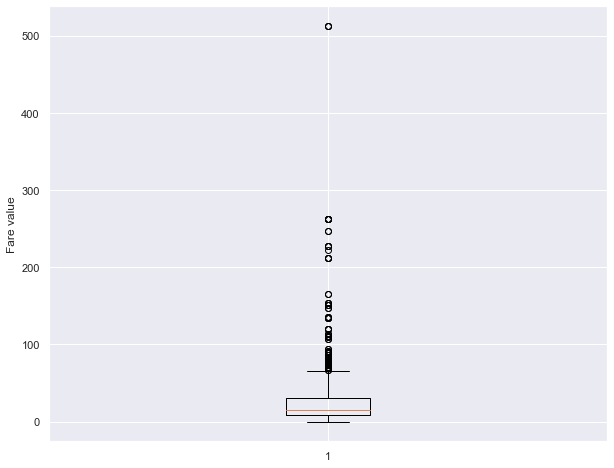

In [86]:
plt.figure(figsize=(10,8))
plt.boxplot(train_df['Fare'])
plt.ylabel('Fare value')


From the above barplot, it is seen that the median fare is around 14 pounds while the high prices could go as high as 500 plus pounds. Hence, we need to divide these fares into fare bands. This will help take care of the non linear distribution of the fare and the presence of so many outliers.

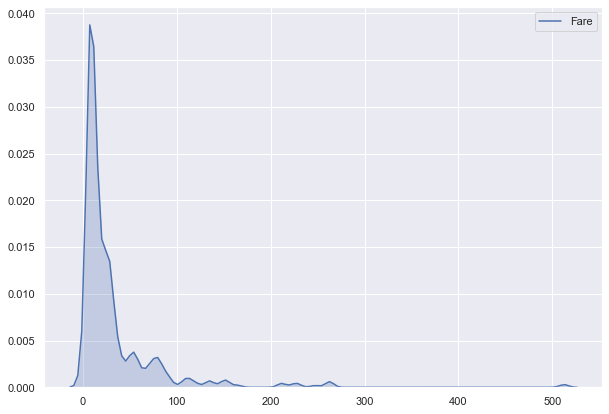

In [87]:
plt.figure(figsize=(10,7))
sns.kdeplot(train_mod['Fare'],shade=True)

The division of fares maybe done as follows:

* 0-50: 1 (General class)
* 50-100: 2 (Economy class)
* 100-200: 3 (Semi-premium)
* 200+ : 4 (Premium)


In [88]:
train_mod.loc[(train_mod['Fare']<51),'Fare band']=1
train_mod.loc[(train_mod['Fare']>50)&(train_mod['Fare']<101),'Fare band']=2
train_mod.loc[(train_mod['Fare']>100)&(train_mod['Fare']<201),'Fare band']=3
train_mod.loc[(train_mod['Fare']>200),'Fare band']=4
train_mod.head()

,Pclass,Fare,Target,Person,Total relatives,C,Q,S,Age band,Fare band
0,3,7.2500,0,1,1,0,0,1,1.0,1.0
1,1,71.2833,1,2,1,1,0,0,2.0,2.0
2,3,7.9250,1,2,0,0,0,1,1.0,1.0
3,1,53.1000,1,2,1,0,0,1,2.0,2.0
4,3,8.0500,0,1,0,0,0,1,2.0,1.0


In [89]:
train_mod.drop('Fare',axis=1,inplace=True)

In [90]:
train_mod.head()

,Pclass,Target,Person,Total relatives,C,Q,S,Age band,Fare band
0,3,0,1,1,0,0,1,1.0,1.0
1,1,1,2,1,1,0,0,2.0,2.0
2,3,1,2,0,0,0,1,1.0,1.0
3,1,1,2,1,0,0,1,2.0,2.0
4,3,0,1,0,0,0,1,2.0,1.0


In [91]:
target_df=pd.DataFrame(columns=['Target'])
target_df['Target']=train_mod['Target']
target_df.head()

,Target
0,0
1,1
2,1
3,1
4,0


In [92]:
target_df['Target'].value_counts()

0    549
1    342
Name: Target, dtype: int64

In [93]:
train_mod.drop('Target',axis=1,inplace=True)

In [94]:
train_mod.head()

,Pclass,Person,Total relatives,C,Q,S,Age band,Fare band
0,3,1,1,0,0,1,1.0,1.0
1,1,2,1,1,0,0,2.0,2.0
2,3,2,0,0,0,1,1.0,1.0
3,1,2,1,0,0,1,2.0,2.0
4,3,1,0,0,0,1,2.0,1.0


The above data is now preprocessed and can be used for Machine Learning.

# Machine Learning

In [95]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(train_mod,target_df,test_size=0.2,shuffle=True,random_state=365)


### KNN

In [96]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [97]:
y_knn_pred=knn.predict(X_test)

In [98]:
print('Score with KNN on test dataset:{}'.format(np.round(knn.score(X_test,y_test) *100,2)))
print('Score with KNN on train dataset:{}'.format(np.round(knn.score(X_train,y_train) *100,2)))

Score with KNN on test dataset:78.21
Score with KNN on train dataset:84.41


In [99]:
from sklearn.metrics import confusion_matrix
cnf_knn=confusion_matrix(y_knn_pred,y_test)

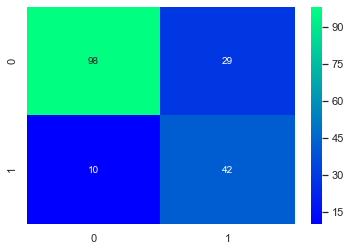

In [100]:
sns.heatmap(cnf_knn,annot=True,cmap='winter')

### Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:
reg_log=LogisticRegression()

In [103]:
reg_log.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
y_log_pred=reg_log.predict(X_test)

In [105]:
print('Score with Logistic regression on test dataset:{}'.format(np.round(reg_log.score(X_test,y_test) *100,2)))
print('Score with Logistic regression on train dataset:{}'.format(np.round(reg_log.score(X_train,y_train) *100,2)))

Score with Logistic regression on test dataset:79.89
Score with Logistic regression on train dataset:80.06


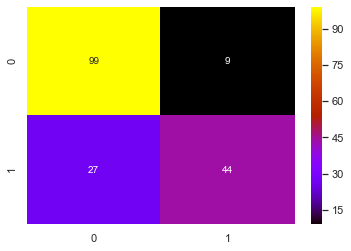

In [106]:
cnf_reg=confusion_matrix(y_test,y_log_pred)
sns.heatmap(cnf_reg,annot=True,cmap='gnuplot')

In [107]:
y_lr=reg_log.fit(X_train,y_train).decision_function(X_test)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0, 0.5, 'True positive rate')

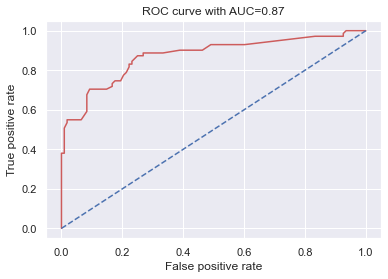

In [108]:
from sklearn.metrics import roc_curve,auc,precision_recall_curve

fpr,tpr,_=roc_curve(y_test,y_lr)
plt.plot(fpr,tpr,color='indianred')
plt.plot([0,1],[0,1],linestyle='--')
auc_reg=auc(fpr,tpr).round(2)
plt.title('ROC curve with AUC={}'.format(auc_reg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

The above figure shows there is good amount of area under the curve.

Text(0, 0.5, 'Recall')

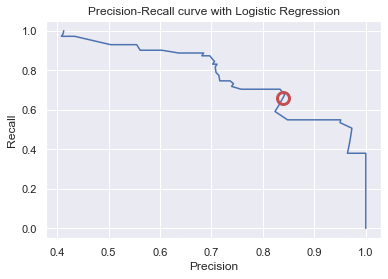

In [133]:
precision,recall,threshold=precision_recall_curve(y_test,y_lr)
closest_zero=np.argmin(np.abs(threshold))
closest_zero_p=precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.plot(precision,recall)
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.title('Precision-Recall curve with Logistic Regression')
plt.xlabel('Precision')
plt.ylabel('Recall')

Hence, an optimum precision vs recall will be about 0.83 and 0.65 respectively

###  SVC

In [110]:
from sklearn.svm import SVC

In [111]:
svc=SVC(gamma=1e-07,C=1e9)
svc.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [112]:
y_svc_pred=svc.predict(X_test)

In [113]:
print('Score with SVC on test dataset:{}'.format(np.round(svc.score(X_test,y_test) *100,2)))
print('Score with SVC on train dataset:{}'.format(np.round(svc.score(X_train,y_train) *100,2)))

Score with SVC on test dataset:81.56
Score with SVC on train dataset:80.62


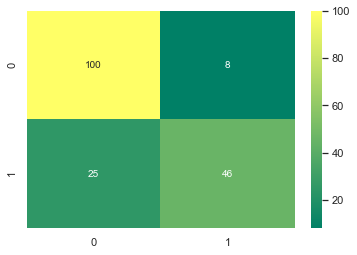

In [114]:
cnf_reg=confusion_matrix(y_test,y_svc_pred)
sns.heatmap(cnf_reg,annot=True,cmap='summer',fmt='g')

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0, 0.5, 'True positive rate')

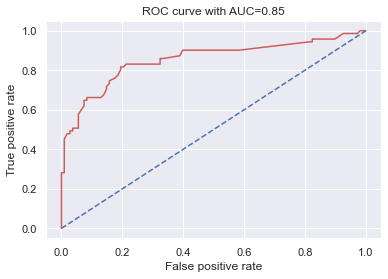

In [130]:
y_svc=svc.fit(X_train,y_train).decision_function(X_test)
fpr,tpr,_=roc_curve(y_test,y_svc)
plt.plot(fpr,tpr,color='indianred')
plt.plot([0,1],[0,1],linestyle='--')
auc_reg=auc(fpr,tpr).round(2)
plt.title('ROC curve with AUC={}'.format(auc_reg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


Text(0, 0.5, 'Recall')

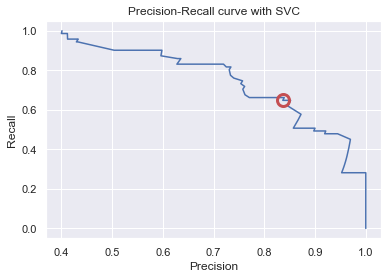

In [134]:
precision,recall,threshold=precision_recall_curve(y_test,y_svc)
closest_zero=np.argmin(np.abs(threshold))
closest_zero_p=precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.plot(precision,recall)
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.title('Precision-Recall curve with SVC')
plt.xlabel('Precision')
plt.ylabel('Recall')

Both the area under curve score and precision-recall curve are very close to logistic regression curves. Hence, their performances are very identical.

## Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [116]:
rfc=RandomForestClassifier()
param_grid={'n_estimators':[5,7,9,10], 'max_depth':[5,7,9,10]}
grid_search=GridSearchCV(rfc,param_grid,scoring='roc_auc')

In [117]:
grid_result=grid_search.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWa

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection

In [118]:
grid_result.best_params_

{'max_depth': 5, 'n_estimators': 10}

In [119]:
grid_result.best_score_

0.8584659922741783

In [120]:
y_rfc_pred=grid_result.predict(X_test)

In [121]:
print('Score with RFC on test dataset:{}'.format(np.round(grid_result.score(X_test,y_test) *100,2)))
print('Score with RFC on train dataset:{}'.format(np.round(grid_result.score(X_train,y_train) *100,2)))

Score with RFC on test dataset:88.56
Score with RFC on train dataset:88.81


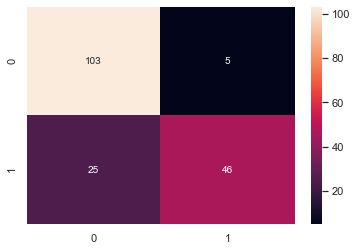

In [128]:
cnf_rfc=confusion_matrix(y_test,y_rfc_pred)
sns.heatmap(cnf_rfc,annot=True,fmt='g')

## Decision Tree

In [123]:
from sklearn.tree import DecisionTreeClassifier

In [124]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [125]:
y_dtc_pred=dtc.predict(X_test)

In [126]:
print('Score with DTC on test dataset:{}'.format(np.round(dtc.score(X_test,y_test) *100,2)))
print('Score with DTC on train dataset:{}'.format(np.round(dtc.score(X_train,y_train) *100,2)))

Score with DTC on test dataset:81.01
Score with DTC on train dataset:86.8


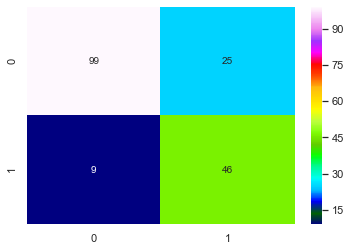

In [127]:
cnf_dtc=confusion_matrix(y_dtc_pred,y_test)
sns.heatmap(cnf_dtc,annot=True,cmap='gist_ncar')

## Stochastic Gradient Descent

In [167]:
from sklearn.linear_model import SGDClassifier

In [168]:
sgd=SGDClassifier(max_iter=10)
sgd.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=10,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [169]:
y_sgd_pred=sgd.predict(X_test)

In [170]:
print('Score with SGD on test dataset:{}'.format(np.round(sgd.score(X_test,y_test) *100,2)))
print('Score with SGD on train dataset:{}'.format(np.round(sgd.score(X_train,y_train) *100,2)))

Score with SGD on test dataset:76.54
Score with SGD on train dataset:77.67


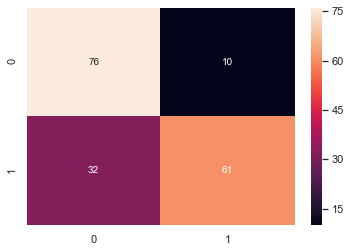

In [142]:
cnf_sgd=confusion_matrix(y_sgd_pred,y_test)
sns.heatmap(cnf_sgd,annot=True)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Text(0, 0.5, 'True positive rate')

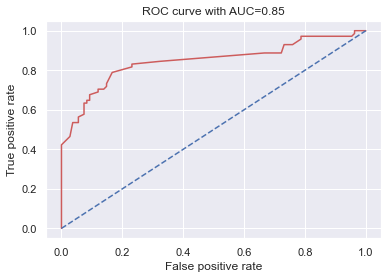

In [145]:
y_sgd=sgd.fit(X_train,y_train).decision_function(X_test)
fpr,tpr,_=roc_curve(y_test,y_sgd)
plt.plot(fpr,tpr,color='indianred')
plt.plot([0,1],[0,1],linestyle='--')
auc_reg=auc(fpr,tpr).round(2)
plt.title('ROC curve with AUC={}'.format(auc_reg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')



Text(0, 0.5, 'Recall')

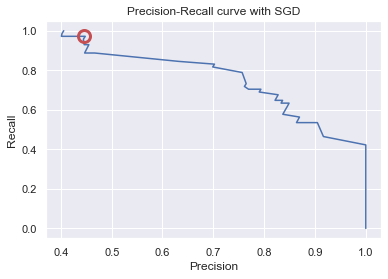

In [147]:
precision,recall,threshold=precision_recall_curve(y_test,y_sgd)
closest_zero=np.argmin(np.abs(threshold))
closest_zero_p=precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.plot(precision,recall)
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.title('Precision-Recall curve with SGD')
plt.xlabel('Precision')
plt.ylabel('Recall')

As we can see from the above curve, the optimum precision of this model is quite low (0.45) while it's recall is high. The other models fared better comparatively.

## Naive Bayes 

In [143]:
from sklearn.naive_bayes import GaussianNB

In [148]:
nb=GaussianNB()
nb.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [149]:
y_nb_pred=nb.predict(X_test)

In [150]:
print('Score with Naive Bayes on test dataset:{}'.format(np.round(nb.score(X_test,y_test) *100,2)))
print('Score with Naive Bayes on train dataset:{}'.format(np.round(nb.score(X_train,y_train) *100,2)))

Score with Naive Bayes on test dataset:75.98
Score with Naive Bayes on train dataset:73.03


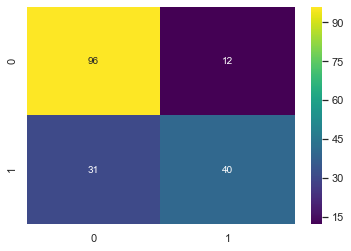

In [151]:
cnf_nb=confusion_matrix(y_test,y_nb_pred)
sns.heatmap(cnf_nb,annot=True,cmap='viridis')

# Comparison of training scores of the models

In [155]:
score_df=pd.DataFrame(columns=['Model name','Train score'])

In [156]:
models=['KNN','SVC','Naive Bayes','Decision Tree','Logistic Regression','Random Forest','SGD']
score_df['Model name']=models

In [172]:
scores=[np.round(knn.score(X_train,y_train) *100,2),
        np.round(svc.score(X_train,y_train) *100,2),
        np.round(nb.score(X_train,y_train) *100,2),
        np.round(dtc.score(X_train,y_train) *100,2),
        np.round(reg_log.score(X_train,y_train) *100,2),
        np.round(grid_result.score(X_train,y_train) *100,2),
        np.round(sgd.score(X_train,y_train) *100,2)]
score_df['Train score']=scores

In [173]:
score_df

,Model name,Train score
0,KNN,84.41
1,SVC,80.62
2,Naive Bayes,73.03
3,Decision Tree,86.80
4,Logistic Regression,80.06
5,Random Forest,88.81
6,SGD,77.67


As we can see, Random forest classifier with max_depth=5 and n_estimators=10 gives the best train scores followed by Decision tree. Hence, tree based models have perfored better.

Let us now perform a K-cross fold validation to prevent any overfitting issues.

# K-Fold cross validation

In [175]:
from sklearn.model_selection import cross_val_score

In [178]:
rfc_opt=RandomForestClassifier(max_depth=5,n_estimators=10)

Let us perform a 5 fold cross validation.

In [181]:
score_cv=cross_val_score(rfc_opt,X_train,y_train,cv=5,scoring='accuracy')

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection

In [188]:
cv_df=pd.DataFrame(columns=['Cross validated score'])
cv_scores=np.round(score_cv*100,2)

In [191]:
cv_df['Cross validated score']=cv_scores
cv_df.index=cv_df.index + 1

In [192]:
cv_df

,Cross validated score
1,81.94
2,80.28
3,86.62
4,75.35
5,78.87


The above scores are far more realistic than the high result of approximately 90% shown.

Let us analyse the mean and standard deviation of all the cross validated scores.

In [197]:
print('Cross validated mean score: {}'.format(cv_scores.mean()))
print('Cross validated score standard deviation: {}'.format(np.round(cv_scores.std(),2)))

Cross validated mean score: 80.612
Cross validated score standard deviation: 3.71


Hence, the standard deviation is at an appreciated low value. This means our cross validation scores are nearly similar for each fold. 

## We can finalise that we shall be using random forest classifier on our final test dataset.

# B) Testing phase

In [280]:
test_df=pd.read_csv('datasets/test.csv')

In [281]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## We shall perform the same data wrangling and preprocessing which we have performed on the training dataset for the model to predict accurately.

In [282]:
test_df.drop(['Name','Cabin','Ticket'],axis=1,inplace=True)

In [283]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Target,Person,Total relatives
0,1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,male,1
1,2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,female,1
2,3,Yes,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,female,0
3,4,Yes,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,female,1
4,5,No,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,male,0


In [284]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [285]:
test_df['Total relatives']=test_df['SibSp']+test_df['Parch']
test_df.drop(['SibSp','Parch'],axis=1,inplace=True)

In [286]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Total relatives
0,892,3,male,34.5,7.8292,Q,0
1,893,3,female,47.0,7.0000,S,1
2,894,2,male,62.0,9.6875,Q,0
3,895,3,male,27.0,8.6625,S,0
4,896,3,female,22.0,12.2875,S,2


In [287]:
embarks=pd.get_dummies(test_df['Embarked'])

In [288]:
test_df=test_df.merge(embarks,on=test_df.index)

In [289]:
test_df.drop(['key_0','Embarked'],axis=1,inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Total relatives,C,Q,S
0,892,3,male,34.5,7.8292,0,0,1,0
1,893,3,female,47.0,7.0000,1,0,0,1
2,894,2,male,62.0,9.6875,0,0,1,0
3,895,3,male,27.0,8.6625,0,0,0,1
4,896,3,female,22.0,12.2875,2,0,0,1


In [290]:
test_df['Person']=test_df[['Age','Sex']].apply(child,axis=1)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Total relatives,C,Q,S,Person
0,892,3,male,34.5,7.8292,0,0,1,0,male
1,893,3,female,47.0,7.0000,1,0,0,1,female
2,894,2,male,62.0,9.6875,0,0,1,0,male
3,895,3,male,27.0,8.6625,0,0,0,1,male
4,896,3,female,22.0,12.2875,2,0,0,1,female


In [291]:
test_df['Person']=test_df['Person'].map({'male':1,'female':2,'child':3})
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Total relatives,C,Q,S,Person
0,892,3,male,34.5,7.8292,0,0,1,0,1
1,893,3,female,47.0,7.0000,1,0,0,1,2
2,894,2,male,62.0,9.6875,0,0,1,0,1
3,895,3,male,27.0,8.6625,0,0,0,1,1
4,896,3,female,22.0,12.2875,2,0,0,1,2


In [292]:
test_df['Age'].median()

27.0

In [293]:
test_df['Age']=test_df['Age'].fillna(test_df['Age'].median())

In [294]:
test_df.loc[test_df['Age']<=16,'Age band']=0
test_df.loc[(test_df['Age']>16) & (test_df['Age']<33),'Age band']=1
test_df.loc[(test_df['Age']>32) & (test_df['Age']<49),'Age band']=2
test_df.loc[(test_df['Age']>48) & (test_df['Age']<65),'Age band']=3
test_df.loc[test_df['Age']>64,'Age band']=4
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Total relatives,C,Q,S,Person,Age band
0,892,3,male,34.5,7.8292,0,0,1,0,1,2.0
1,893,3,female,47.0,7.0000,1,0,0,1,2,2.0
2,894,2,male,62.0,9.6875,0,0,1,0,1,3.0
3,895,3,male,27.0,8.6625,0,0,0,1,1,1.0
4,896,3,female,22.0,12.2875,2,0,0,1,2,1.0


In [295]:
test_df['Fare']=test_df['Fare'].fillna(test_df['Fare'].median())

In [296]:
test_df.isna().any()

PassengerId        False
Pclass             False
Sex                False
Age                False
Fare               False
Total relatives    False
C                  False
Q                  False
S                  False
Person             False
Age band           False
dtype: bool

In [297]:
test_df.loc[(test_df['Fare']<51),'Fare band']=1
test_df.loc[(test_df['Fare']>50)&(test_df['Fare']<101),'Fare band']=2
test_df.loc[(test_df['Fare']>100)&(test_df['Fare']<201),'Fare band']=3
test_df.loc[(test_df['Fare']>200),'Fare band']=4
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Total relatives,C,Q,S,Person,Age band,Fare band
0,892,3,male,34.5,7.8292,0,0,1,0,1,2.0,1.0
1,893,3,female,47.0,7.0000,1,0,0,1,2,2.0,1.0
2,894,2,male,62.0,9.6875,0,0,1,0,1,3.0,1.0
3,895,3,male,27.0,8.6625,0,0,0,1,1,1.0,1.0
4,896,3,female,22.0,12.2875,2,0,0,1,2,1.0,1.0


In [298]:
test_df.drop(['Sex','Age','Fare'],axis=1,inplace=True)
test_df.head()

,PassengerId,Pclass,Total relatives,C,Q,S,Person,Age band,Fare band
0,892,3,0,0,1,0,1,2.0,1.0
1,893,3,1,0,0,1,2,2.0,1.0
2,894,2,0,0,1,0,1,3.0,1.0
3,895,3,0,0,0,1,1,1.0,1.0
4,896,3,2,0,0,1,2,1.0,1.0


As we can see, the test data is now preprocessed and can be used for machine learning.

## Applying machine learning to the test dataframe

In [299]:
train_mod.head()

,Pclass,Person,Total relatives,C,Q,S,Age band,Fare band
0,3,1,1,0,0,1,1.0,1.0
1,1,2,1,1,0,0,2.0,2.0
2,3,2,0,0,0,1,1.0,1.0
3,1,2,1,0,0,1,2.0,2.0
4,3,1,0,0,0,1,2.0,1.0


In [302]:
test_df[train_mod.columns].head()

,Pclass,Person,Total relatives,C,Q,S,Age band,Fare band
0,3,1,0,0,1,0,2.0,1.0
1,3,2,1,0,0,1,2.0,1.0
2,2,1,0,0,1,0,3.0,1.0
3,3,1,0,0,0,1,1.0,1.0
4,3,2,2,0,0,1,1.0,1.0


In [304]:
rfc_opt.fit(X_train,y_train)

/Users/rinbaruah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [306]:
y_final_predictions=rfc_opt.predict(test_df[train_mod.columns])

In [307]:
final_predictions_df=pd.DataFrame(columns=['PassengerId','Survived'])
final_predictions_df['PassengerId']=test_df['PassengerId']

In [309]:
final_predictions_df['Survived']=y_final_predictions

In [311]:
final_predictions_df.isna().any()

PassengerId    False
Survived       False
dtype: bool

In [313]:
final_predictions_df.to_csv('Final survival predictions.csv')